In [32]:
import math
import random
from datetime import datetime

import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

QUANTITY_OF_TEST_CASES = 20

def params_to_string(params: dict) -> str:
    name = ""
    for key, value in params.items():
        name += f"{key}_{value}-"
    return name[:-1]

class RotationAndFlipLayer(torch.nn.Module):
    """
    A layer that converts a (B, L, C, W, H) into a (B * 8 * L, C, W, H)
    """
    def __init__(self):
        super().__init__()
        self.metadata = None
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # batch, levels, channels, width, height = x.shape
        
        # x = x.reshape(batch * levels, channels, width, height)
        
        # width_dim = len(x.shape) - 2
        # height_dim = len(x.shape) - 1
        
        # rot90: torch.Tensor = x.rot90(k=1, dims=(width_dim, height_dim))
        # rot180: torch.Tensor = x.rot90(k=2, dims=(width_dim, height_dim))
        # rot270: torch.tensor = x.rot90(k=3, dims=(width_dim, height_dim))
        # flipped: torch.Tensor = x.flip(dims=(width_dim,))
        # flipped_rot90: torch.Tensor = flipped.rot90(k=1, dims=(width_dim, height_dim))
        # flipped_rot180: torch.Tensor = flipped.rot90(k=2, dims=(width_dim, height_dim))
        # flipped_rot270: torch.Tensor = flipped.rot90(k=3, dims=(width_dim, height_dim))

        # transforms = (
        #     x,
        #     rot90,
        #     rot180,
        #     rot270,
        #     flipped, 
        #     flipped_rot90,
        #     flipped_rot180,
        #     flipped_rot270,
        # )
        
        # # transforms = (
        # #     x,
        # #     x,
        # #     x,
        # #     x,
        # #     x, 
        # #     x,
        # #     x,
        # #     x,
        # # )
        
        # self.metadata = { "batch": batch, "levels": levels, "transforms": len(transforms) }
        
        # return torch.cat(transforms, dim=0)
        
        ######################################################################################
        
        batch, levels, channels, width, height = x.shape

        width_dim = len(x.shape) - 2
        height_dim = len(x.shape) - 1
        
        flipped: torch.Tensor = x.flip(dims=(height_dim,))
        flipped_rot90: torch.Tensor = flipped.rot90(k=1, dims=(width_dim, height_dim))
        flipped_rot180: torch.Tensor = flipped.rot90(k=2, dims=(width_dim, height_dim))
        flipped_rot270: torch.Tensor = flipped.rot90(k=3, dims=(width_dim, height_dim))
        rot90: torch.Tensor = x.rot90(k=1, dims=(width_dim, height_dim))
        rot180: torch.Tensor = x.rot90(k=2, dims=(width_dim, height_dim))
        rot270: torch.tensor = x.rot90(k=3, dims=(width_dim, height_dim))

        transforms = (
            x,
            rot90,
            rot180,
            rot270,
            flipped, 
            flipped_rot90,
            flipped_rot180,
            flipped_rot270,
        )

        # transforms = (
        #     x,
        #     x,
        #     x,
        #     x,
        #     x, 
        #     x,
        #     x,
        #     x,
        # )
        x = torch.cat(transforms, dim=1)
        x = x.reshape(batch * levels * len(transforms), channels, width, height)

        self.metadata = { "batch": batch, "levels": levels, "transforms": 8 }
        return x

        #####################################################################################
        # batch, levels, channels, width, height = x.shape

        # width_dim = len(x.shape) - 2
        # height_dim = len(x.shape) - 1        

        # final = []

        # for i_batch in x.chunk(batch):
        #     transforms = []
        #     for i_level in i_batch.chunk(levels, dim=1):
        #         flipped: torch.Tensor = i_level.flip(dims=(width_dim,))
        #         flipped_rot90: torch.Tensor = i_level.rot90(k=1, dims=(width_dim, height_dim))
        #         flipped_rot180: torch.Tensor = i_level.rot90(k=2, dims=(width_dim, height_dim))
        #         flipped_rot270: torch.Tensor = i_level.rot90(k=3, dims=(width_dim, height_dim))
        #         rot90: torch.Tensor = i_level.rot90(k=1, dims=(width_dim, height_dim))
        #         rot180: torch.Tensor = i_level.rot90(k=2, dims=(width_dim, height_dim))
        #         rot270: torch.tensor = i_level.rot90(k=3, dims=(width_dim, height_dim))
        #         rot_flips = torch.cat((
        #                 i_level,
        #                 rot90,
        #                 rot180,
        #                 rot270,
        #                 flipped,
        #                 flipped_rot90,
        #                 flipped_rot180,
        #                 flipped_rot270
        #             ), dim=1) 
        #         transforms.append(rot_flips)
        #     final.append(torch.cat(transforms, dim=1))

        # x = torch.cat(final)
        # x = x.reshape(batch * levels * 8, 1, width, height)
        # self.metadata = { "batch": batch, "levels": levels, "transforms": 8 }
        # return x

def test_rotation_and_flip_layer():
    layer = RotationAndFlipLayer()
    
    for _ in range(QUANTITY_OF_TEST_CASES):
        batch = 2 # random.randint(1, 100)
        levels = 5 # random.randint(1, 100)

        x = torch.zeros((batch, levels, 1, 30, 30))
        out = layer.forward(x)

        transforms = layer.metadata["transforms"]

        expected = batch * levels * 8
        assert out.shape == torch.Size([expected, 1, 30, 30]), f"Test failed with batch {batch} and level {levels}"

        del x
        del out

    del layer

test_rotation_and_flip_layer()
# batch = 2
# levels = 5

# x = torch.rand(batch, levels, 1, 2, 2)
# batch, levels, channels, width, height = x.shape
# width_dim = len(x.shape) - 2
# height_dim = len(x.shape) - 1
# print(x.shape)

# final = []

# for i_batch in x.chunk(batch):
#     transforms = []
#     for i_level in i_batch.chunk(levels, dim=1):
#         flipped: torch.Tensor = i_level.flip(dims=(width_dim,))
#         flipped_rot90: torch.Tensor = i_level.rot90(k=1, dims=(width_dim, height_dim))
#         flipped_rot180: torch.Tensor = i_level.rot90(k=2, dims=(width_dim, height_dim))
#         flipped_rot270: torch.Tensor = i_level.rot90(k=3, dims=(width_dim, height_dim))
#         rot90: torch.Tensor = i_level.rot90(k=1, dims=(width_dim, height_dim))
#         rot180: torch.Tensor = i_level.rot90(k=2, dims=(width_dim, height_dim))
#         rot270: torch.tensor = i_level.rot90(k=3, dims=(width_dim, height_dim))
#         rot_flips = torch.cat((
#                 i_level,
#                 rot90,
#                 rot180,
#                 rot270,
#                 flipped,
#                 flipped_rot90,
#                 flipped_rot180,
#                 flipped_rot270
#             ), dim=1) 
#         transforms.append(rot_flips)
#     final.append(torch.cat(transforms, dim=1))

# x = torch.cat(final)
# x = x.reshape(batch * levels * 8, 1, width, height)
# print(x.shape)


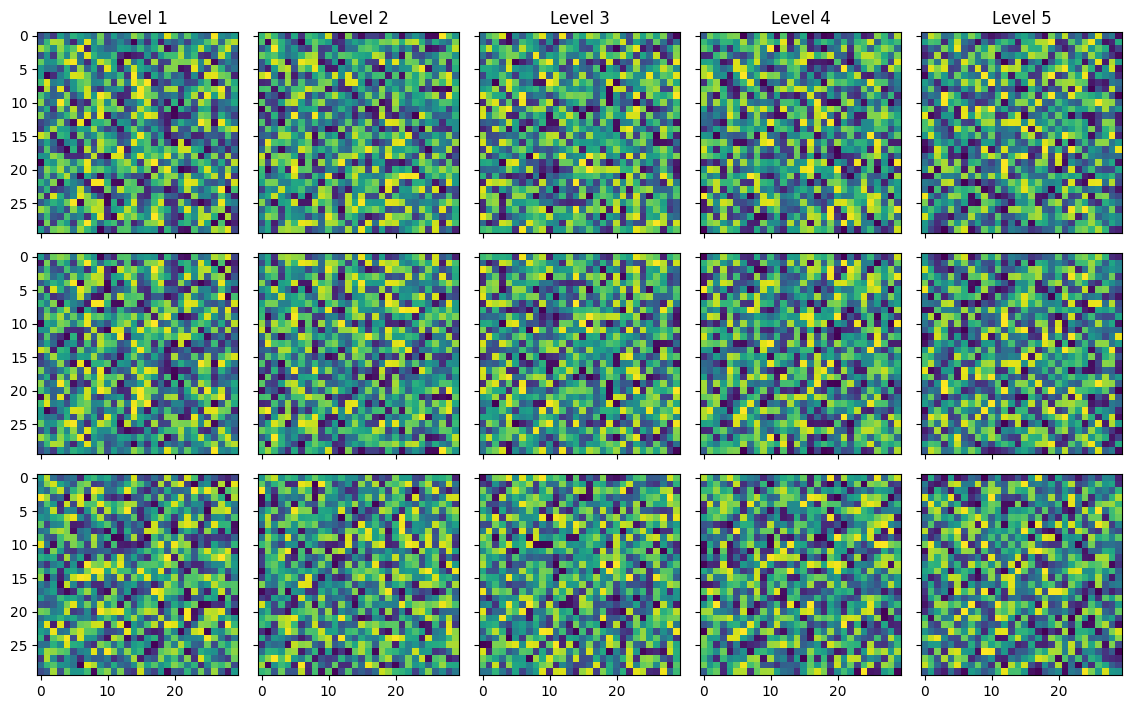

In [33]:
class ImageVisualizer:
    def __init__(self):
        self._samples_array: list[tensor.Tensor] = []
        self._levels = 5

    @property
    def nsamples(self) -> int:
        return len(self._samples_array)
    
    def plot(self) -> None:
        fig = plt.figure(figsize=(14., 14.))
        grid = ImageGrid(fig, 111, nrows_ncols=(int(self.nsamples / self._levels), self._levels), axes_pad=0.2)
        for ax, im in zip(grid, self._samples_array):
            ax.imshow(im)

        for level in range(1, self._levels + 1):
            grid.axes_all[level - 1].set_title(f"Level {level}")
        plt.show()
        
    def add(self, images: torch.Tensor) -> None:
        if len(images.shape) != 4:
            raise ValueError(f"Expected 4D tensor: (levels, channels, width, height), recieved: {images.shape}")

        if images.shape[0] != self._levels: # has to be 5 levels
            raise ValueError(f"Expected 5 levels, recieved: {images.shape[0]}")
        
        self._samples_array.extend([im.squeeze().numpy().copy() for im in images.chunk(self._levels)])

    def clean(self) -> None:
        self._samples_array = []

def test_image_visualizer():
    t1 = torch.rand(5, 1, 30, 30)
    t2 = t1.flip(dims=(2,))
    t3 = t1.rot90(dims=(2, 3))

    visualizer = ImageVisualizer()
    visualizer.add(t1)
    visualizer.add(t2)
    visualizer.add(t3)
    
    assert visualizer.nsamples == 15

    visualizer.plot()

    del visualizer
    del t3
    del t2
    del t1

test_image_visualizer()

torch.Size([80, 1, 15, 15])


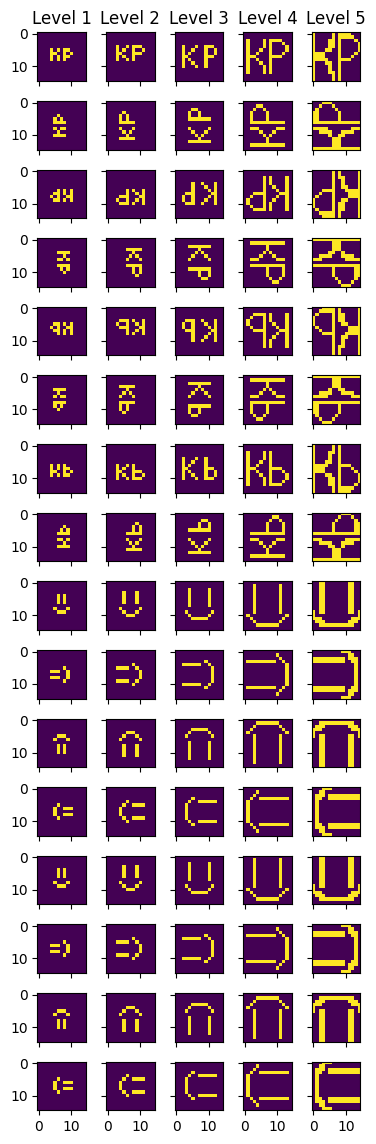

In [34]:
x = torch.Tensor(
    [
        [
        	[
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,1,0,1,0,1,1,0,0,0,0,0],
            	[0,0,0,0,1,1,0,0,1,0,1,0,0,0,0],
            	[0,0,0,0,1,0,1,0,1,1,0,0,0,0,0],
            	[0,0,0,0,1,0,1,0,1,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            ]
        ],
        [
            [
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,1,0,0,1,0,1,1,1,0,0,0,0],
            	[0,0,0,1,0,1,0,0,1,0,0,1,0,0,0],
            	[0,0,0,1,1,0,0,0,1,1,1,0,0,0,0],
            	[0,0,0,1,0,1,0,0,1,0,0,0,0,0,0],
            	[0,0,0,1,0,0,1,0,1,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            ]
        ],
        [
            [
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,1,0,0,0,1,0,0,1,1,1,0,0,0],
                [0,0,1,0,0,1,0,0,0,1,0,0,1,0,0],
                [0,0,1,0,1,0,0,0,0,1,0,0,1,0,0],
                [0,0,1,1,0,0,0,0,0,1,1,1,0,0,0],
                [0,0,1,0,1,0,0,0,0,1,0,0,0,0,0],
                [0,0,1,0,0,1,0,0,0,1,0,0,0,0,0],
                [0,0,1,0,0,0,1,0,0,1,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            ]
        ],
        [
            [
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,1,0,0,0,0,1,0,1,1,1,1,0,0,0],
            	[0,1,0,0,0,0,1,0,1,0,0,0,1,0,0],
            	[0,1,0,0,0,0,1,0,1,0,0,0,0,1,0],
            	[0,1,0,0,0,1,0,0,1,0,0,0,0,1,0],
            	[0,1,0,0,1,0,0,0,1,0,0,0,1,0,0],
            	[0,1,1,1,0,0,0,0,1,1,1,1,0,0,0],
            	[0,1,0,0,1,0,0,0,1,0,0,0,0,0,0],
            	[0,1,0,0,0,1,0,0,1,0,0,0,0,0,0],
            	[0,1,0,0,0,0,1,0,1,0,0,0,0,0,0],
            	[0,1,0,0,0,0,1,0,1,0,0,0,0,0,0],
            	[0,1,0,0,0,0,1,0,1,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            ]
        ],
        [
            [
            	[1,0,0,0,0,0,1,0,1,1,1,1,0,0,0],
            	[1,0,0,0,0,0,1,0,1,1,1,1,1,0,0],
            	[1,0,0,0,0,1,1,0,1,0,0,0,0,1,0],
            	[1,0,0,0,0,1,1,0,1,0,0,0,0,0,1],
            	[1,0,0,0,0,1,1,0,1,0,0,0,0,0,1],
            	[1,0,0,0,1,1,0,0,1,0,0,0,0,0,1],
            	[1,1,1,1,0,0,0,0,1,0,0,0,0,1,0],
            	[1,1,1,1,0,0,0,0,1,0,0,0,1,0,0],
            	[1,1,1,1,1,0,0,0,1,1,1,1,0,0,0],
            	[1,0,0,0,1,1,0,0,1,0,0,0,0,0,0],
            	[1,0,0,0,0,1,0,0,1,0,0,0,0,0,0],
            	[1,0,0,0,0,1,0,0,1,0,0,0,0,0,0],
            	[1,0,0,0,0,1,1,0,1,0,0,0,0,0,0],
            	[1,0,0,0,0,0,1,0,1,0,0,0,0,0,0],
            	[1,0,0,0,0,0,1,0,1,0,0,0,0,0,0]
            ]
        ]
    ]
)

y = torch.Tensor(
    [
        [
            [
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,1,0,1,0,0,0,0,0,0],
                [0,0,0,0,0,0,1,0,1,0,0,0,0,0,0],
                [0,0,0,0,0,0,1,0,1,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,1,0,0,0,1,0,0,0,0,0],
                [0,0,0,0,0,0,1,1,1,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            ]
        ],
        [
            [
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,1,0,0,0,1,0,0,0,0,0],
            	[0,0,0,0,0,1,0,0,0,1,0,0,0,0,0],
            	[0,0,0,0,0,1,0,0,0,1,0,0,0,0,0],
            	[0,0,0,0,0,1,0,0,0,1,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
            	[0,0,0,0,0,1,0,0,0,1,0,0,0,0,0],
            	[0,0,0,0,0,0,1,1,1,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            ]
        ],
        [
            [
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
            	[0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
            	[0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
            	[0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
            	[0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
            	[0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,1,0,0,0,0,0,0,0,1,0,0,0],
            	[0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
            	[0,0,0,0,0,1,1,1,1,1,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            ]
        ],
        [
            [
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            	[0,0,0,1,0,0,0,0,0,0,0,1,0,0,0],
            	[0,0,0,1,0,0,0,0,0,0,0,1,0,0,0],
            	[0,0,0,1,0,0,0,0,0,0,0,1,0,0,0],
            	[0,0,0,1,0,0,0,0,0,0,0,1,0,0,0],
            	[0,0,0,1,0,0,0,0,0,0,0,1,0,0,0],
            	[0,0,0,1,0,0,0,0,0,0,0,1,0,0,0],
            	[0,0,0,1,0,0,0,0,0,0,0,1,0,0,0],
            	[0,0,0,1,0,0,0,0,0,0,0,1,0,0,0],
            	[0,0,0,1,0,0,0,0,0,0,0,1,0,0,0],
            	[0,1,0,0,0,0,0,0,0,0,0,0,0,1,0],
            	[0,0,1,0,0,0,0,0,0,0,0,0,1,0,0],
            	[0,0,0,1,0,0,0,0,0,0,0,1,0,0,0],
            	[0,0,0,0,1,1,1,1,1,1,1,0,0,0,0],
            	[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            ]
        ],
        [
            [
                [0,0,1,1,0,0,0,0,0,0,0,1,1,0,0],
                [0,0,1,1,0,0,0,0,0,0,0,1,1,0,0],
                [0,0,1,1,0,0,0,0,0,0,0,1,1,0,0],
                [0,0,1,1,0,0,0,0,0,0,0,1,1,0,0],
                [0,0,1,1,0,0,0,0,0,0,0,1,1,0,0],
                [0,0,1,1,0,0,0,0,0,0,0,1,1,0,0],
                [0,0,1,1,0,0,0,0,0,0,0,1,1,0,0],
                [0,0,1,1,0,0,0,0,0,0,0,1,1,0,0],
                [0,0,1,1,0,0,0,0,0,0,0,1,1,0,0],
                [1,0,1,1,0,0,0,0,0,0,0,1,1,0,1],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [1,1,1,0,0,0,0,0,0,0,0,0,1,1,1],
                [0,1,1,1,0,0,0,0,0,0,0,1,1,1,0],
                [0,0,1,1,1,1,1,1,1,1,1,1,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            ]
        ]
    ]
)
_x = torch.stack([x, y])
_x.shape

_vis = ImageVisualizer()
_layer = RotationAndFlipLayer()
_out = _layer.forward(_x)
print(_out.shape)
for i in range(16):
    _min, _max = i * 5, (i + 1) * 5
    _vis.add(_out[_min:_max])

_vis.plot()

In [35]:
# chunks = []
# for transform in x.chunk(n_transform):
#     partitions = [batch.reshape(-1) for batch in transform.chunk(batch_size)]
#     chunks.append(torch.stack(partitions))
# return torch.stack(chunks).permute(1, 0, 2)

In [36]:
chunks = []

_vis1 = ImageVisualizer()
_vis2 = ImageVisualizer()
for transform in _out.chunk(2):
    for partition in transform.chunk(8):
        _vis1.add(partition)
        

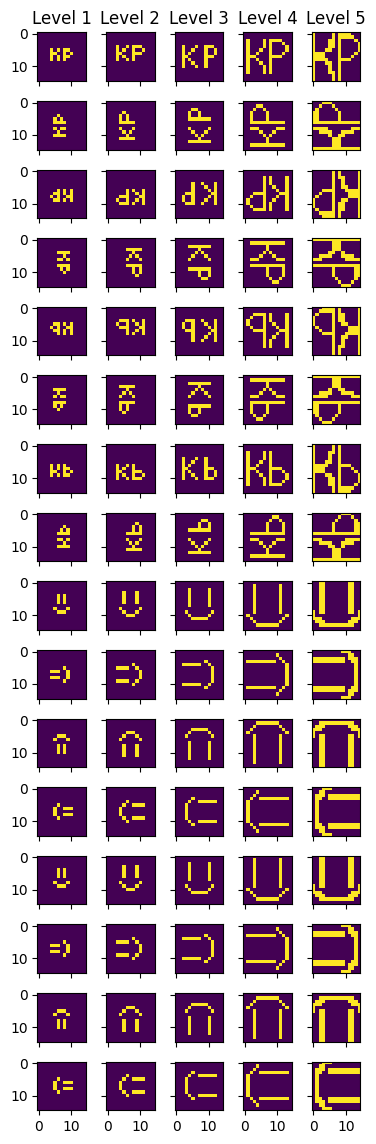

In [37]:
_vis1.plot()

In [38]:
class DELIGHTModel(torch.nn.Module):
    """
    DELIGHT implementation written in torch.

    Allows inputs of ([B]atch, [L]evel, 1, 30, 30).

    """
    def __init__(self, 
                 debug: bool = False,
                 levels: int = 5, 
                 nconv1: int = 52, 
                 nconv2: int = 57, 
                 nconv3: int = 41, 
                 ndense: int = 685
    ):
        super().__init__()
        self.debug = debug
        self.LEVELS = levels
        self.CONV2D_ONE_OUT_CHANNELS = nconv1
        self.CONV2D_TWO_OUT_CHANNELS = nconv2
        self.CONV2D_THREE_OUT_CHANNELS = nconv3
        self.LINEAR_TWO_IN = ndense

        h = w = 30
        conv_kernel_size = 3
        mp_kernel_size = 2

        self.rot_and_flip = RotationAndFlipLayer()
        self.conv1 = torch.nn.Conv2d(
            in_channels=1,
            out_channels=self.CONV2D_ONE_OUT_CHANNELS, 
            kernel_size=conv_kernel_size
        )
        
        self.conv2 = torch.nn.Conv2d(
            in_channels=self.conv1.out_channels, 
            out_channels=self.CONV2D_TWO_OUT_CHANNELS,
            kernel_size=conv_kernel_size
        )
        
        self.conv3 = torch.nn.Conv2d(
            in_channels=self.conv2.out_channels, 
            out_channels=self.CONV2D_THREE_OUT_CHANNELS, 
            kernel_size=conv_kernel_size
        )
        
        self.relu = torch.nn.ReLU()
        self.max_pool = torch.nn.MaxPool2d(kernel_size=mp_kernel_size)
        self.flatten = torch.nn.Flatten()
        
        self.bottleneck = torch.nn.Sequential(
            self.conv1,
            self.relu,
            self.max_pool, 
            self.conv2,
            self.relu,
            self.max_pool,
            self.conv3,
            self.relu,
            self.flatten,
        )

        linear_in = self._compute_fc1_features(
            width=w,
            height=h,
            conv_kernel_size=conv_kernel_size,
            mp_kernel_size=mp_kernel_size
        )

        self.fc1 = torch.nn.Linear(in_features=linear_in, out_features=self.LINEAR_TWO_IN)
        self.fc2 = torch.nn.Linear(in_features=self.LINEAR_TWO_IN, out_features=2)
        self.tanh = torch.nn.Tanh()

    def _compute_fc1_features(self, *, width: int, height: int, conv_kernel_size: int, mp_kernel_size: int) -> int:
        height = height - conv_kernel_size + 1          # conv2d 1 
        height = math.floor((height - mp_kernel_size)/2 + 1)  # maxpool2d 1 
        height = height - conv_kernel_size + 1          # conv2d 2
        height = math.floor((height - mp_kernel_size)/2 + 1)  # maxpool2d 2
        height = height - conv_kernel_size + 1          # conv2d 3

        width = width - conv_kernel_size + 1          # conv2d 1
        width = math.floor((width - mp_kernel_size)/2 + 1)  # maxpool2d 1
        width = width - conv_kernel_size + 1          # conv2d 2
        width = math.floor((width - mp_kernel_size)/2 + 1)  # maxpool2d 2
        width = width - conv_kernel_size + 1          # conv2d 3
        return height * width * self.CONV2D_THREE_OUT_CHANNELS * self.LEVELS
                
    def forward(self, x: torch.Tensor) -> torch.Tensor:                
        # Apply flips and rotations over level (L) dimension
        if self.debug:
            print(f"pre rot_and_flips: {x.shape}")
        
        x = self.rot_and_flip(x)
        batch_size = self.rot_and_flip.metadata["batch"]
        n_transforms = self.rot_and_flip.metadata["transforms"]
        
        if self.debug:
            print(f"pre bottleneck: {x.shape}")
        
        # Bottleneck
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.flatten(x)

        if self.debug:
            print(f"Post bottleneck: {x.shape}")

        # Undo transformations
        x = x.reshape(batch_size, n_transforms, -1)
        
        if self.debug:
            print(f"Post undo: {x.shape}")
        # Linear
        x = self.fc1(x)
        if self.debug:
            print(f"Post fc1: {x.shape}")
        x = self.tanh(x)
        x = self.fc2(x)
        if self.debug:
            print(f"Post fc2: {x.shape}")
        
        x = x.reshape((batch_size, n_transforms * 2))

        if self.debug:
            print(f"final: {x.shape}")
        
        return x
def test_input_output_parameters_on_delight_model():
    for _ in range(QUANTITY_OF_TEST_CASES):
        batch = random.randint(1, 32)
        levels = random.randint(1, 5)

        x = torch.zeros((batch, levels, 1, 30, 30))
        model = DELIGHTModel(debug=True, levels=levels)

        try:
            out = model.forward(x)
        except RuntimeError:
            assert False, f"Runtime error on model with batch {batch} and levels {levels}"
        
        expected = torch.Size([batch, 16])
        assert out.shape == expected, f"Failed with batch {batch} and levels {levels} => {out.shape} != {expected}"
        del out
        del model
        del x

test_input_output_parameters_on_delight_model()

pre rot_and_flips: torch.Size([27, 3, 1, 30, 30])
pre bottleneck: torch.Size([648, 1, 30, 30])
Post bottleneck: torch.Size([648, 656])
Post undo: torch.Size([27, 8, 1968])
Post fc1: torch.Size([27, 8, 685])
Post fc2: torch.Size([27, 8, 2])
final: torch.Size([27, 16])
pre rot_and_flips: torch.Size([8, 5, 1, 30, 30])
pre bottleneck: torch.Size([320, 1, 30, 30])
Post bottleneck: torch.Size([320, 656])
Post undo: torch.Size([8, 8, 3280])
Post fc1: torch.Size([8, 8, 685])
Post fc2: torch.Size([8, 8, 2])
final: torch.Size([8, 16])
pre rot_and_flips: torch.Size([10, 4, 1, 30, 30])
pre bottleneck: torch.Size([320, 1, 30, 30])
Post bottleneck: torch.Size([320, 656])
Post undo: torch.Size([10, 8, 2624])
Post fc1: torch.Size([10, 8, 685])
Post fc2: torch.Size([10, 8, 2])
final: torch.Size([10, 16])
pre rot_and_flips: torch.Size([28, 4, 1, 30, 30])
pre bottleneck: torch.Size([896, 1, 30, 30])
Post bottleneck: torch.Size([896, 656])
Post undo: torch.Size([28, 8, 2624])
Post fc1: torch.Size([28, 8, 

In [39]:
import os
from enum import Enum
from typing import Union
from dataclasses import dataclass

import numpy as np
from torch.utils.data import Dataset

class CustomDatasetType(Enum):
    TRAIN = "TRAIN"
    TEST = "TEST"
    VALIDATION = "VALIDATION"
    
@dataclass
class CustomDatasetOptions:
    dataset_type: CustomDatasetType
    n_levels: int
    fold: int
    mask: bool
    object: bool

    def get_filenames(self) -> str:
        if self.dataset_type == CustomDatasetType.TRAIN:
            X = "X_train_nlevels%i_fold%i_mask%s_objects%s.npy" % (self.n_levels, self.fold, self.mask, self.object)
            y = "y_train_nlevels%i_fold%i_mask%s_objects%s.npy" % (self.n_levels, self.fold, self.mask, self.object)
        elif self.dataset_type == CustomDatasetType.TEST:
            X = "X_test_nlevels%i_mask%s_objects%s.npy" % (self.n_levels, self.mask, self.object)
            y = "y_test_nlevels%i_mask%s_objects%s.npy" % (self.n_levels, self.mask, self.object)
        else:
            X = "X_val_nlevels%i_fold%i_mask%s_objects%s.npy" % (self.n_levels, self.fold, self.mask, self.object)
            y = "y_val_nlevels%i_fold%i_mask%s_objects%s.npy" % (self.n_levels, self.fold, self.mask, self.object)
            
        return X, y
            
class CustomDataset(Dataset):    
    def __init__(self, options: CustomDatasetOptions, source: Union[str, None] = None):
        self.source = source if source is not None else "/home/fforster/SNHosts/data"
        X_path, y_path = options.get_filenames()
        self.X = torch.Tensor(np.load(os.path.join(self.source, X_path))).permute(0, 3, 1, 2)
        self.y = torch.Tensor(self.rotateY(np.load(os.path.join(self.source, y_path))))

    def rotateY(self, y: np.ndarray) -> np.ndarray:
        y90 = [-1, 1] * y[:, ::-1]
        y180 = [-1, 1] * y90[:, ::-1]
        y270 = [-1, 1] * y180[:, ::-1]
        yflip = [1, -1] * y
        yflip90 = [-1, 1] * yflip[:, ::-1]
        yflip180 = [-1, 1] * yflip90[:, ::-1]
        yflip270 = [-1, 1] * yflip180[:, ::-1]

        return np.concatenate([
            y,
            y90,
            y180,
            y270,
            yflip,
            yflip90,
            yflip180,
            yflip270
        ], axis=1)

        # return np.concatenate([
        #     y,
        #     y,
        #     y,
        #     y,
        #     y,
        #     y,
        #     y,
        #     y
        # ], axis=1)
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx: int):
        X = self.X[idx]
        y = self.y[idx]

        if len(X.shape) == 3: # has no channel information
            levels, width, height = X.shape 
            X = X.reshape(levels, 1, width, height) # asume 1 channel information
        return X, y

In [40]:
train_opt = CustomDatasetOptions(
    dataset_type=CustomDatasetType.TRAIN,
    n_levels=5,
    fold=0,
    mask=False,
    object=True
)
test_opt = CustomDatasetOptions(
    dataset_type=CustomDatasetType.TEST,
    n_levels=5,
    fold=0,
    mask=False,
    object=True
)
val_opt = CustomDatasetOptions(
    dataset_type=CustomDatasetType.VALIDATION,
    n_levels=5,
    fold=0,
    mask=False,
    object=True
)

batch_size = 32
source = "/home/keviinplz/universidad/tesis/snhost/data"
train = CustomDataset(options=train_opt, source=source)
test = CustomDataset(options=test_opt, source=source)
val = CustomDataset(options=val_opt, source=source)

In [41]:
from torch.utils.data import DataLoader

params = {
    "debug": False,
    "levels": 5,
    "nconv1": 16,
    "nconv2": 32,
    "nconv3": 32,
    "ndense": 128
}

train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val, batch_size=batch_size, shuffle=True)
model = DELIGHTModel(**params)

In [42]:
%load_ext tensorboard
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)

name = params_to_string(params)
writer = SummaryWriter('runs/delight_{}_{}'.format(name, ts))

EPOCHS = 50

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [43]:
def train_one_epoch(epoch: int, tb_writer: SummaryWriter, device: str = "cuda"):
        running_loss = 0.
        last_loss = 0.
    
        # Here, we use enumerate(training_loader) instead of
        # iter(training_loader) so that we can track the batch
        # index and do some intra-epoch reporting
        pbar = tqdm(train_dl, leave=False, position=1)
        for i, data in enumerate(pbar):
            # Every data instance is an input + label pair
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            # Zero your gradients for every batch!
            optimizer.zero_grad()
    
            # Make predictions for this batch
            outputs = model(inputs)
    
            # Compute the loss and its gradients
            loss = loss_fn(outputs, labels)
            loss.backward()
    
            # Adjust learning weights
            optimizer.step()
    
            # Gather data and report
            running_loss += loss.item()
            if i % batch_size == batch_size - 1:
                last_loss = running_loss / batch_size # loss per batch
                pbar.set_description('batch {} loss: {}'.format(i + 1, last_loss))
                tb_x = epoch * len(train_dl) + i + 1
                tb_writer.add_scalar('Loss/train', last_loss, tb_x)
                running_loss = 0.
    
        return last_loss

In [44]:
%tensorboard --logdir runs

best_vloss = 1_000_000.
device = "cuda"

os.makedirs("states", exist_ok=True)

pbar = tqdm(range(EPOCHS), leave=False, position=0)

for epoch in pbar:
    pbar.set_description("Running epoch %s" % epoch)

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    model.to(device)
    avg_loss = train_one_epoch(epoch, writer, device)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dl):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            
            voutputs = model(vinputs)

            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    pbar.set_description("LOSS train %s valid %s" % (avg_loss, avg_vloss), refresh=False)

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'states/model_{}_{}'.format(ts, epoch)
        torch.save(model.state_dict(), model_path)

    epoch += 1

Reusing TensorBoard on port 6006 (pid 95170), started 0:06:23 ago. (Use '!kill 95170' to kill it.)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

In [45]:
X_train, y_train = next(iter(train_dl))
X_train.shape, y_train.shape

(torch.Size([32, 5, 1, 30, 30]), torch.Size([32, 16]))